# 朴素贝叶斯与应用
by 寒小阳(hanxiaoyang.ml@gmail.com)


## 贝叶斯理论简单回顾

在我们有一大堆样本（包含特征和类别）的时候，我们非常容易通过统计得到  p(特征|类别) .

大家又都很熟悉下述公式：

$$ p(x)p(y \vert x)=p(y)p(x \vert y)$$
 
所以做一个小小的变换

$$p(特征)p(类别 \vert 特征)=p(类别)p(特征\vert 类别)$$
 
$$ p(类别 \vert 特征)=p(类别)p(特征 \vert 类别)p(特征) $$ 
 
## 独立假设

看起来很简单，但实际上，你的特征可能是很多维的

$$p(\mathrm{features} \vert \mathrm{class})=p(f_0,f_1, \cdots ,f_n \vert c)$$
 
就算是2个维度吧，可以简单写成

$$p(f_0,f_1 \vert c)=p(f_1 \vert c,f_0)p(f_0\vert c)$$
 
这时候我们加一个特别牛逼的假设：特征之间是独立的。这样就得到了

$$ p(f_0,f_1 \vert c)=p(f_1\vert c)p(f_0 \vert c)$$ 
 
其实也就是：

$$ p(f_0,f_1, \cdots ,f_n \vert c)=\prod^n_ip(f_i \vert c)$$ 
 
## 贝叶斯分类器
OK，回到机器学习，其实我们就是对每个类别计算一个概率 p(c_i) ，然后再计算所有特征的条件概率 p(f_j|c_i) ，那么分类的时候我们就是依据贝叶斯找一个最可能的类别：

$$p(\mathrm{class}_i|f_0,f_1,\cdots,f_n)= \frac{p(\mathrm{class}_i)}{p(f_0,f_1,\cdots,f_n)}\prod^n_jp(f_j|c_i)$$

## 文本分类问题
下面我们来看一个文本分类问题，经典的新闻主题分类，用朴素贝叶斯怎么做。

In [1]:
import os
import time
import random
import jieba  #处理中文
#import nltk  #处理英文
import sklearn
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

In [2]:
#粗暴的词去重
def make_word_set(words_file):
    words_set = set()
    with open(words_file, 'r') as fp:
        for line in fp.readlines():
            word = line.strip()
            if len(word)>0 and word not in words_set: # 去重
                words_set.add(word)
    return words_set

In [20]:
# 文本处理，也就是样本生成过程
def text_processing(folder_path, test_size=0.2):
    folder_list = os.listdir(folder_path)
    data_list = []
    class_list = []

    # 遍历文件夹
    for folder in folder_list:
        new_folder_path = os.path.join(folder_path, folder)
        files = os.listdir(new_folder_path)
        # 读取文件
        j = 1
        for file in files:
            if j > 100: # 怕内存爆掉，只取100个样本文件，你可以注释掉取完
                break
            with open(os.path.join(new_folder_path, file), 'r') as fp:
                raw_text = fp.read()
            ## 是的，随处可见的jieba中文分词
            jieba.enable_parallel(4) # 开启并行分词模式，参数为并行进程数，不支持windows
            word_cut = jieba.cut(raw_text, cut_all=False) # 精确模式，返回的结构是一个可迭代的genertor
            word_list = list(word_cut) # genertor转化为list，每个词unicode格式
            jieba.disable_parallel() # 关闭并行分词模式
            
            data_list.append(word_list) #训练集list
            class_list.append(folder) #类别
            j += 1
    
    ## 粗暴地划分训练集和测试集
    data_class_list = list(zip(data_list, class_list))
    random.shuffle(data_class_list)
    index = int(len(data_class_list)*test_size)+1
    train_list = data_class_list[index:]
    test_list = data_class_list[:index]
    train_data_list, train_class_list = zip(*train_list)
    test_data_list, test_class_list = zip(*test_list)
    
    #其实可以用sklearn自带的部分做
    #train_data_list, test_data_list, train_class_list, test_class_list = sklearn.cross_validation.train_test_split(data_list, class_list, test_size=test_size)
    

    # 统计词频放入all_words_dict
    all_words_dict = {}
    for word_list in train_data_list:
        for word in word_list:
            if word in all_words_dict :
                all_words_dict[word] += 1
            else:
                all_words_dict[word] = 1

    # key函数利用词频进行降序排序
    all_words_tuple_list = sorted(all_words_dict.items(), key=lambda f:f[1], reverse=True) # 内建函数sorted参数需为list
    all_words_list = [w for w, c in all_words_tuple_list] # list(zip(*all_words_tuple_list)[0])

    return all_words_list, train_data_list, test_data_list, train_class_list, test_class_list

In [21]:
def words_dict(all_words_list, deleteN, stopwords_set=set()):
    # 选取特征词
    feature_words = []
    n = 1
    for t in range(deleteN, len(all_words_list), 1):
        if n > 1000: # feature_words的维度1000
            break
            
        if not all_words_list[t].isdigit() and all_words_list[t] not in stopwords_set and 1<len(all_words_list[t])<5:
            feature_words.append(all_words_list[t])
            n += 1
    return feature_words

In [22]:
# 文本特征
def text_features(train_data_list, test_data_list, feature_words, flag='nltk'):
    def text_features(text, feature_words):
        text_words = set(text)
        ## -----------------------------------------------------------------------------------
        if flag == 'nltk':
            ## nltk特征 dict
            features = {word:1 if word in text_words else 0 for word in feature_words}
        elif flag == 'sklearn':
            ## sklearn特征 list
            features = [1 if word in text_words else 0 for word in feature_words]
        else:
            features = []
        ## -----------------------------------------------------------------------------------
        return features
    train_feature_list = [text_features(text, feature_words) for text in train_data_list]
    test_feature_list = [text_features(text, feature_words) for text in test_data_list]
    return train_feature_list, test_feature_list

In [23]:
# 分类，同时输出准确率等
def text_classifier(train_feature_list, test_feature_list, train_class_list, test_class_list, flag='nltk'):
    ## -----------------------------------------------------------------------------------
    if flag == 'nltk':
        ## 使用nltk分类器
        train_flist = zip(train_feature_list, train_class_list)
        test_flist = zip(test_feature_list, test_class_list)
        classifier = nltk.classify.NaiveBayesClassifier.train(train_flist)
        test_accuracy = nltk.classify.accuracy(classifier, test_flist)
    elif flag == 'sklearn':
        ## sklearn分类器
        classifier = MultinomialNB().fit(train_feature_list, train_class_list)
        test_accuracy = classifier.score(test_feature_list, test_class_list)
    else:
        test_accuracy = []
    return test_accuracy

start
[0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.6842105263157895, 0.7368421052631579, 0.7368421052631579, 0.6842105263157895, 0.6842105263157895, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.6842105263157895, 0.6842105263157895, 0.6842105263157895, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.5789473684210527, 0.5789473684210527, 0.631578947368421, 0.5789473684210527, 0.5789473684210527, 0.5263157894736842, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5263157894736842, 0.47368421052631576, 0.5789473684210527, 0.631578947368421, 0.5263157894736842]


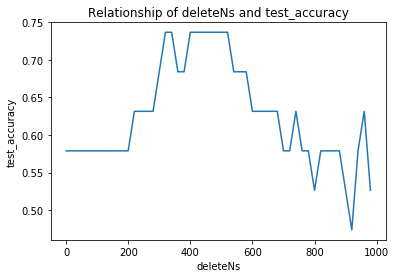

finished


In [25]:
print("start")

## 文本预处理
folder_path = './Database/SogouC/Sample'
all_words_list, train_data_list, test_data_list, train_class_list, test_class_list = text_processing(folder_path, test_size=0.2)

# 生成stopwords_set
stopwords_file = './stopwords_cn.txt'
stopwords_set = make_word_set(stopwords_file)

## 文本特征提取和分类
# flag = 'nltk'
flag = 'sklearn'
deleteNs = range(0, 1000, 20)
test_accuracy_list = []
for deleteN in deleteNs:
    # feature_words = words_dict(all_words_list, deleteN)
    feature_words = words_dict(all_words_list, deleteN, stopwords_set)
    train_feature_list, test_feature_list = text_features(train_data_list, test_data_list, feature_words, flag)
    test_accuracy = text_classifier(train_feature_list, test_feature_list, train_class_list, test_class_list, flag)
    test_accuracy_list.append(test_accuracy)
print(test_accuracy_list)

# 结果评价
#plt.figure()
plt.plot(deleteNs, test_accuracy_list)
plt.title('Relationship of deleteNs and test_accuracy')
plt.xlabel('deleteNs')
plt.ylabel('test_accuracy')
plt.show()
#plt.savefig('result.png')

print("finished")